# Lecture 4: Random numbers and simulation

[Download on GitHub](https://github.com/NumEconCopenhagen/lectures-2020)

[<img src="https://mybinder.org/badge_logo.svg">](https://mybinder.org/v2/gh/NumEconCopenhagen/lectures-2020/master?urlpath=lab/tree/04/Random_numbers_and_simulation.ipynb)

1. [Exchange economy with many consumers](#Exchange-economy-with-many-consumers)
2. [Random numbers](#Random-numbers)
3. [Demand](#Demand)
4. [Interactive figures](#Interactive-figures)
5. [Equilibrium](#Equilibrium)
6. [Numerical integration by Monte Carlo](#Numerical-integration-by-Monte-Carlo)
7. [Load and save](#Load-and-save)
8. [Summary](#Summary)


You will learn how to use a random number generator with a seed and produce simulation results (**numpy.random**, **scipy.stats**), and calcuate the expected value of a random variable through Monte Carlo integration. You will learn how to save your results for later use (**pickle**). Finally, you will learn how to make your figures interactive (**ipywidgets**).

**Links:**

* [numpy.random](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html)
* [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
* [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html)
* datacamp on [pickle](https://www.datacamp.com/community/tutorials/pickle-python-tutorial)

**Imports:** We now import all the modules, we need for this notebook. Importing everything in the beginning makes it more clear what modules the notebook relies on.

In [1]:
import pickle
import numpy as np

from scipy.stats import norm # normal distribution

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import ipywidgets as widgets

<a id="Exchange-economy-with-many-consumers"></a>

# 1. Exchange economy with many consumers

Consider an **exchange economy** with

1. 2 goods, $(x_1,x_2)$
2. $N$ consumers indexed by $j \in \{1,2,\dots,N\}$
3. Preferences are Cobb-Douglas with uniformly *heterogenous* coefficients

$$
\begin{aligned}
u^{j}(x_{1},x_{2}) & = x_{1}^{\alpha_{j}}x_{2}^{1-\alpha_{j}}\\
 & \,\,\,\alpha_{j}\sim\mathcal{U}(\underline{\mu},\overline{\mu})\\
 & \,\,\,0<\underline{\mu}<\overline{\mu}<1
\end{aligned}
$$

4. Endowments are *homogenous* and given by

$$
\boldsymbol{e}^{j}=(e_{1}^{j},e_{2}^{j})=(k,1),\,k>0
$$

The implied **demand functions** are:

$$
\begin{aligned}
x_{1}^{\star j}(p_{1},p_{2},e^{j})&=&\alpha_{j}\frac{I}{p_{1}}=\alpha_{j}\frac{kp_{1}+p_{2}}{p_{1}} \\
x_{2}^{\star j}(p_{1},p_{2},e^{j})&=&(1-\alpha_{j})\frac{I}{p_{2}}=(1-\alpha_{j})\frac{kp_{1}+p_{2}}{p_{2}}
\end{aligned}
$$

The **equilibrium** for a random draw of $\alpha = \{\alpha_1,\alpha_2,\dots,\alpha_N\}$ is a set of prices $p_1$ and $p_2$ satifying:

$$
\begin{aligned}
x_1(p_1,p_2) = \sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) &= \sum_{j=1}^N e_1^j = Nk \\
x_2(p_1,p_2) = \sum_{j=1}^N x_{2}^{\star j}(p_{1},p_{2},e^{j}) &= \sum_{j=1}^N e_2^j = N
\end{aligned}
$$

**Problem:** Solve for this equilibrium. But how do we handle the randomness? We need a random number generator (RNG).

**Warm-up**: Choose parameters and define demand functions.

In [2]:
# a. parameters
N = 1000
k = 2 # endowment
mu_low = 0.1 # lower bound on alpha
mu_high = 0.9 # upper bound on alpha

# b. demand functions
def demand_good_1_func(alpha,p1,p2,k):
    I = k*p1+p2
    return alpha*I/p1

def demand_good_2_func(alpha,p1,p2,k):
    I = k*p1+p2
    return (1-alpha)*I/p2

<a id="Random-numbers"></a>

# 2. Random numbers

The two main approaches to generating random numbers are:

1. **Physical observations** of random processes (radioactive decay,  atmospheric noise, roulette wheels, etc.)
2. **Algorithms** creating pseudo-random numbers

**Pseudo-random numbers** satisfy propoerties such that they are as good as random. It should be impossible (for all practical purposes) to calculate, or otherwise guess, from any given subsequence, any previous or future values in the sequence.

**More information:** See this [video](https://www.youtube.com/watch?v=C82JyCmtKWg&app=desktop#fauxfullscreen) by Infinite Series.

## 2.1 Simple example: Middle-square method

Proposed by **John von Neumann**:

1. Start with a $N$ digit number
2. Square the number
3. Pad the number with leading zeros making it a $2N$ digit number
4. Extract the middle $N$ digits (*your random number*)
5. Return to step 1 to generate one more

> **Pro:** Simple and easy to implement. Conceptually somewhat similar to more advanced methods (e.g. *Mersenne-Twister* used by *numpy*).
>
> **Con:** Cycles can be no longer than $8^N$ periods. Many repeating cycles are very short. Internal state is directly observable.
>
> **Conclusion:** Can not be used in practice.

**Code:** An implementation in Python for $N = 4$ digit random integers:

In [3]:
def rng(number,max_iter=100): 
    
    already_seen = [] # list of seen numbers
    
    i = 0
    while number not in already_seen and i < max_iter:
        
        already_seen.append(number)
        squared = number**2
        padded = str(squared).zfill(8) # add leading zeros
        number = int(padded[2:6]) # extract middle 4 numbers
        
        print(f"square = {squared:8d}, padded = {padded} -> {number:4d}")
        i += 1

A reasonable cycle:

In [4]:
rng(4653)

square = 21650409, padded = 21650409 -> 6504
square = 42302016, padded = 42302016 -> 3020
square =  9120400, padded = 09120400 -> 1204
square =  1449616, padded = 01449616 -> 4496
square = 20214016, padded = 20214016 -> 2140
square =  4579600, padded = 04579600 -> 5796
square = 33593616, padded = 33593616 -> 5936
square = 35236096, padded = 35236096 -> 2360
square =  5569600, padded = 05569600 -> 5696
square = 32444416, padded = 32444416 -> 4444
square = 19749136, padded = 19749136 -> 7491
square = 56115081, padded = 56115081 -> 1150
square =  1322500, padded = 01322500 -> 3225
square = 10400625, padded = 10400625 -> 4006
square = 16048036, padded = 16048036 ->  480
square =   230400, padded = 00230400 -> 2304
square =  5308416, padded = 05308416 -> 3084
square =  9511056, padded = 09511056 -> 5110
square = 26112100, padded = 26112100 -> 1121
square =  1256641, padded = 01256641 -> 2566
square =  6584356, padded = 06584356 -> 5843
square = 34140649, padded = 34140649 -> 1406
square =  

A short cycle:

In [5]:
rng(540)

square =   291600, padded = 00291600 -> 2916
square =  8503056, padded = 08503056 -> 5030
square = 25300900, padded = 25300900 -> 3009
square =  9054081, padded = 09054081 ->  540


No cycle at all:

In [6]:
rng(3792)

square = 14379264, padded = 14379264 -> 3792


## 2.2 Numpy

Numpy provides various functions for drawing random numbers. We can, for example, draw random integers between 0 and 10000:

In [7]:
X = np.random.randint(0,10000,size=5)
print(X)

[8073 2704 8061 3554 7713]


**Problem:** How can we reproduce our results the next time we open Python?

**Solution:** Use a seed! Choose the seed, and reset the random number generator:

In [8]:
np.random.seed(2000)
print(np.random.uniform(size=5))
print(np.random.uniform(size=5))
np.random.seed(2000)
print(np.random.uniform(size=5))

[0.57051729 0.56452876 0.48844183 0.33647775 0.37586818]
[0.53203587 0.06810629 0.58452906 0.23789776 0.16075658]
[0.57051729 0.56452876 0.48844183 0.33647775 0.37586818]


> **Note:** The first and third draws above are exactly the same.

We can also **save and load the state** of the random number generator.

In [9]:
# a. save state
state = np.random.get_state()

# b. draw some random number
print(np.random.uniform(size=5))
print(np.random.uniform(size=5))

# c. reset state 
np.random.set_state(state)

# d. draw the same random numbers again
print(np.random.uniform(size=5))
print(np.random.uniform(size=5))

[0.53203587 0.06810629 0.58452906 0.23789776 0.16075658]
[0.15211915 0.12706922 0.32744117 0.69415387 0.35896647]
[0.53203587 0.06810629 0.58452906 0.23789776 0.16075658]
[0.15211915 0.12706922 0.32744117 0.69415387 0.35896647]


> **Note**: You should *only set the seed once* per program. Changing seed might brake randomness.

## 2.3 Different distributions

Draw random numbers from various distributions:

In [10]:
X = np.random.normal(loc=0,scale=1,size=10**6)
Y = np.random.beta(a=5,b=2,size=10**6)
Z = np.random.uniform(low=-2,high=2,size=10**6)
vec = np.array([-2.5,-2.0,-1.5,-1.0,-0.5,0,0.5,1.0,1.5,2,2.5])
prob = (np.linspace(-1,1,vec.size)+0.1)**2 # all positive numbers
prob /= np.sum(prob) # make them sum to one
K = np.random.choice(vec,size=10**6,p=prob)

Plot the various distributions:

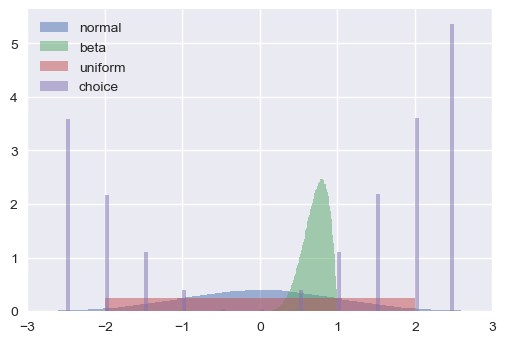

In [11]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.hist(X,bins=100,density=True,alpha=0.5,label='normal') # alpha < 1 = transparent
ax.hist(Y,bins=100,density=True,alpha=0.5,label='beta')
ax.hist(Z,bins=100,density=True,alpha=0.5,label='uniform')
ax.hist(K,bins=100,density=True,alpha=0.5,label='choice')
ax.set_xlim([-3,3])
ax.legend(loc='upper left'); # note: the ; stops output from being printed

**Task:** Follow this [link](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html). Choose a distribution and add it to the figure above.

## 2.4 Analytical results

How close are our draws to a normal distribution?

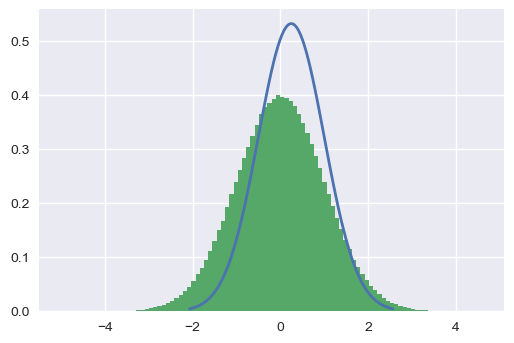

In [12]:
from scipy.stats import norm

# a. create analytical distribution
loc_guess = 0.25
scale_guess = 0.75
# loc_guess, scale_guess = norm.fit(X)
F = norm(loc=loc_guess,scale=scale_guess)

# b. vector of x values
x_low = F.ppf(0.001) # x value where cdf is 0.001
x_high = F.ppf(0.999) # x value where cdf is 0.999
x = np.linspace(x_low,x_high,100)

# c. compare
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.plot(x,F.pdf(x),lw=2,label='estimated')
ax.hist(X,bins=100,density=True,histtype='stepfilled');

**Task:** Make the pdf fit the historgram.

## 2.5 Permutations

In [13]:
class dice_cup:
    
    def __init__(self,ndice):
        self.ndice = ndice
    
    def roll(self):
        self.dice = np.random.randint(1,7,size=self.ndice)
        print(self.dice)
        
    def shuffle(self):
        np.random.shuffle(self.dice)
        print(self.dice)
        
    def roll_and_sum(self):
        pass
        
my_dice_cup = dice_cup(4)
my_dice_cup.roll()
my_dice_cup.shuffle()
my_dice_cup.roll_and_sum()

[5 1 1 4]
[1 4 5 1]


**Task:** Add a method ``roll_and_sum()`` to the class above, which rolls and print the sum of the dice. Compare the value of your roll to your neighbor.

<a id="Demand"></a>

# 3. Demand

$$ 
x_1(p_1,p_2) = \sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) = \alpha_{j}\frac{kp_{1}+p_{2}}{p_{1}}
$$

Find demand distribution and total demand:

In [14]:
def find_demand_good_1(alphas,p1,p2,k):
    dist = demand_good_1_func(alphas,p1,p2,k)
    total = dist.sum()
    return dist,total

Calculate for various prices:

In [15]:
# a. draw alphas
alphas = np.random.uniform(low=mu_low,high=mu_high,size=N)

# b. prices
p1_vec = [0.5,1,2,5]
p2 = 1

# c. demand
dists = np.empty((len(p1_vec),N))
totals = np.empty(len(p1_vec))
for i,p1 in enumerate(p1_vec):
    dist,total = find_demand_good_1(alphas,p1,p2,k)
    dists[i,:] = dist
    totals[i] = total

Plot the results:

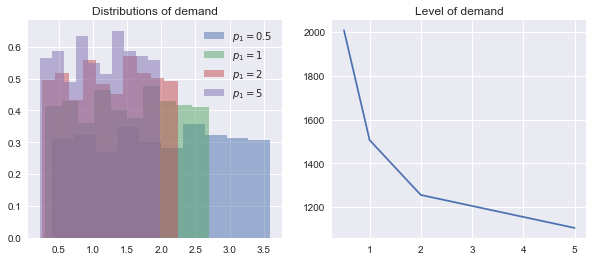

In [16]:
fig = plt.figure(figsize=(10,4))

ax_left = fig.add_subplot(1,2,1)
ax_left.set_title('Distributions of demand')
for i,p1 in enumerate(p1_vec):
    ax_left.hist(dists[i],density=True,alpha=0.5,label=f'$p_1 = {p1}$')
ax_left.legend(loc='upper right')

ax_right = fig.add_subplot(1,2,2)
ax_right.set_title('Level of demand')
ax_right.grid(True)
ax_right.plot(p1_vec,totals)

<a id="Interactive-figures"></a>

# 4. Interactive figures

Create a function constructing a figure:

In [17]:
def interactive_figure(alphas,p1,p2,k):
    
    # a. calculations
    dist,_total = find_demand_good_1(alphas,p1,p2,k)
    
    # b. figure
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax.hist(dist,density=True)
    ax.set_xlim([0,4]) # fixed x range
    ax.set_ylim([0,0.8]) # fixed y range

**Case 1:** Make it interactive with a **slider**

In [18]:
widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    p1=widgets.FloatSlider(description="$p_1$", min=0.1, max=5, step=0.05, value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(FloatSlider(value=2.0, description='$p_1$', max=5.0, min=0.1, step=0.05), Output()), _do…

**Case 2:** Make it interactive with a **textbox**:

In [19]:
widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    p1=widgets.FloatText(description="$p_1$", value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(FloatText(value=2.0, description='$p_1$'), Output()), _dom_classes=('widget-interact',))

**Case 3:** Make it interactive with a **dropdown menu**

In [20]:
widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    p1=widgets.Dropdown(description="$p_1$", options=[0.5,1,1.5,2.0,2.5,3], value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(Dropdown(description='$p_1$', index=3, options=(0.5, 1, 1.5, 2.0, 2.5, 3), value=2.0), O…

**Tasl:** Add a slider for \\(k\\) to the interactive figure below.

In [21]:
# change this code
widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    p1=widgets.FloatSlider(description="$p_1$", min=0.1, max=5, step=0.05, value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(FloatSlider(value=2.0, description='$p_1$', max=5.0, min=0.1, step=0.05), Output()), _do…

<a id="Equilibrium"></a>

# 5. Equilibrium

The equilibrium conditions (demand = supply) were:

$$
\begin{aligned}
\sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) &= Nk \Leftrightarrow Z_1 \equiv \sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) - Nk = 0 \\
\sum_{j=1}^N x_{2}^{\star j}(p_{1},p_{2},e^{j}) &= N \Leftrightarrow Z_2 \equiv \sum_{j=1}^N x_{2}^{\star j}(p_{1},p_{2},e^{j}) - N = 0
\end{aligned}
$$

**Idea:** Solve the first equation. The second is then satisfied due to Walras's law.

**Excess demand functions:**

In [22]:
def excess_demand_good_1_func(alphas,p1,p2,k):
    
    # a. demand
    demand = np.sum(demand_good_1_func(alphas,p1,p2,k))
    
    # b. supply
    supply = k*alphas.size
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

def excess_demand_good_2_func(alphas,p1,p2,k):
    
    # a. demand
    demand = np.sum(demand_good_2_func(alphas,p1,p2,k))
    
    # b. supply
    supply = alphas.size
    
    # c. excess demand
    excess_demand = demand-supply
    
    return excess_demand

**Algorithm:** Choose a tolerance $\epsilon > 0$ and an adjustment factor $\kappa$, and guess on $p_1 > 0$. 

Find the equilibrium price by:

1. Calculate excess demand $Z_1 = \sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) - Nk$
2. If $|Z_1| < \epsilon $ stop
3. If $|Z_1| \geq \epsilon $ set $p_1 = p_1 + \kappa \cdot \frac{Z_1}{N}$
4. Return to step 1

In [23]:
def find_equilibrium(alphas,p1,p2,k,kappa=0.5,eps=1e-8,maxiter=500):
    
    t = 0
    while True:

        # a. step 1: excess demand
        Z1 = excess_demand_good_1_func(alphas,p1,p2,k)
        
        # b: step 2: stop?
        if  np.abs(Z1) < eps or t >= maxiter:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
            break    
    
        # c. step 3: update p1
        p1 = p1 + kappa*Z1/alphas.size
            
        # d. step 4: return 
        if t < 5 or t%25 == 0:
            print(f'{t:3d}: p1 = {p1:12.8f} -> excess demand -> {Z1:14.8f}')
        elif t == 5:
            print('   ...')
            
        t += 1    

    return p1

Find the equilibrium price:

In [24]:
p1 = 1.4
p2 = 1
kappa = 0.1
eps = 1e-8
p1 = find_equilibrium(alphas,p1,p2,k,kappa=kappa,eps=eps)

  0: p1 =   1.33630791 -> excess demand ->  -636.92088467
  1: p1 =   1.27432551 -> excess demand ->  -619.82402224
  2: p1 =   1.21417098 -> excess demand ->  -601.54525131
  3: p1 =   1.15596888 -> excess demand ->  -582.02103644
  4: p1 =   1.09984924 -> excess demand ->  -561.19636337
   ...
 25: p1 =   0.52719273 -> excess demand ->   -52.43951174
 50: p1 =   0.50449211 -> excess demand ->    -0.24293979
 75: p1 =   0.50439371 -> excess demand ->    -0.00099618
100: p1 =   0.50439330 -> excess demand ->    -0.00000408
125: p1 =   0.50439330 -> excess demand ->    -0.00000002
128: p1 =   0.50439330 -> excess demand ->    -0.00000001


**Check:** Ensure that excess demand of both goods are (almost) zero.

In [25]:
Z1 = excess_demand_good_1_func(alphas,p1,p2,k)
Z2 = excess_demand_good_2_func(alphas,p1,p2,k)
print(Z1,Z2)
assert np.abs(Z1) < eps
assert np.abs(Z2) < eps

-8.651113603264093e-09 4.363300831755623e-09


<a id="Numerical-integration-by-Monte-Carlo"></a>

# 6. Numerical integration by Monte Carlo

Numerical integration is the task of computing

$$ 
\mathbb{E}[g(x)]  \text{ where } x \sim F
$$

and $F$ is a known probability distribution and $g$ is a function. 

Relying on the law of large numbers we approximate this integral with

$$
\mathbb{E}[g(x)] \approx \frac{1}{N}\sum_{i=1}^{N} g(x_i) 
$$

where $x_i$ is drawn from $F$ using a random number generator. This is also called **numerical integration by Monte Carlo**.

**Monte Carlo function:**

In [26]:
def g(x):
    return x**2

def MC(N,g,F):
    X = F.rvs(size=N) # rvs = draw N random values from F
    return np.mean(g(X))

**Example** with a normal distribution:

In [27]:
N = 1000
F = norm(loc=0.1,scale=0.5)
print(MC(N,g,F))

0.2813617979965345


Function for drawning \\( K \\) Monte Carlo samples:

In [28]:
def MC_sample(N,g,F,K):
    
    results = np.empty(K)
    for i in range(K):
        results[i] = MC(N,g,F)

    return results

The variance across Monte Carlo samples falls with larger $N$:

In [29]:
K = 1000
for N in [10**2,10**3,10**4,10**5]:
    results = MC_sample(N,g,F,K)
    print(f'N = {N:8d}: {results.mean():.6f} (std: {results.std():.4f})')

N =      100: 0.261205 (std: 0.0361)
N =     1000: 0.260017 (std: 0.0118)
N =    10000: 0.260146 (std: 0.0036)
N =   100000: 0.260016 (std: 0.0011)


<a id="Load-and-save"></a>

# 7. Load and save

## 7.1 Pickle

A good allround method for loading and saving is to use **pickle**. Here is how to save:

In [30]:
# a. variables
my_dict = {'a':1,'b':2}
my_vec = np.array([1,2,3])
my_tupple = (1,4,2)

# b. put them in a dictionary
my_data = {}
my_data['my_dict'] = my_dict
my_data['my_vec'] = my_vec
my_data['my_tupple'] = my_tupple

# c. save the dictionary in a file
with open(f'data.p', 'wb') as f: # wb = write binary
    pickle.dump(my_data, f)

Delete the variables:

In [31]:
del my_dict
del my_vec
del my_tupple

Load the data again:

In [32]:
# a. try
try:
    print(my_tupple)
except:
    print('my_vec does not exist')
    
# b. load    
with open(f'data.p', 'rb') as f: # rb = read binary
    data = pickle.load(f)
    my_dict = data['my_dict']
    my_vec = data['my_vec']
    my_tupple = data['my_tupple']
    
# c. try again
print(my_vec)
print(my_tupple)

my_vec does not exist
[1 2 3]
(1, 4, 2)


## 7.2 Saving with numpy

When only saving/loading **numpy arrays**, an alternative is to use ``np.savez`` (or ``np.savez_compressed``). This is typically faster than pickle.

Here is how to save some data:

In [33]:
my_data = {}
my_data['A'] = np.array([1,2,3])
my_data['B'] = np.zeros((5,8))
my_data['C'] = np.ones((7,3,8))
np.savez(f'data.npz', **my_data)
# '**' unpacks the dictionary

Here is how to load the data again:

In [34]:
# a. delete
del my_data

# a. load all
my_data = {}
with np.load(f'data.npz') as data:
    for key in data.files:
        my_data[key] = data[key]
print(my_data['A'])

# b. load single array
X = np.load(f'data.npz')['A']
print(X)

[1 2 3]
[1 2 3]


<a id="Summary"></a>

# 8. Summary

**This lecture:** We have talked about:

1. numpy.random: Drawing (pseudo-)random numbers (seed, state, distributions)
2. scipy.stats: Using analytical random distributions (ppf, pdf, cdf, rvs)
3. ipywidgets: Making interactive figures
4. pickle and np.savez: Saving and loading data

The method you learned for finding the equilibrium can be used in a lot of models. For example, a simple method can be applied with multiple goods.

**Your work:** Before solving Problem Set 2 read through this notebook and play around with the code.

**Next lecture:** Workflow and debugging. Go through these guides beforehand:

1. [Installing Python and VSCode](https://numeconcopenhagen.netlify.com//guides/python-setup)
2. [Running Python in JupyterLab](https://numeconcopenhagen.netlify.com//guides/jupyterlab)
3. [Running Python in VSCode](https://numeconcopenhagen.netlify.com//guides/vscode-basics)

You must have installed **git** and have a **GitHub account!** (step 2 in [Installing Python and VSCode](https://numeconcopenhagen.netlify.com//guides/python-setup)).

**Finally:** You can begin to think about who you want to work together with for the group assignments. We will talk more about inaugural project next-time.